# 3. Multi-class Vnet on BV

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dataset import *
from vnet import *
from training import *
from niiutility import show_image, show_batch_image

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 3.1 Setup Torch Global Variable, load memory map 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, sampler, SubsetRandomSampler
from torchvision import transforms, utils

import torch.nn.functional as F  # useful stateless functions
import torchvision.transforms as T

#------------------------------- GLOBAL VARIABLES -------------------------------------#

USE_GPU = True
BATCH_SIZE = 2
NUM_WORKERS = 6
NUM_TRAIN = 72
LEARNING_RATE = 1e-2

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    print('using GPU for training')
else:
    device = torch.device('cpu')

using GPU for training


In [4]:
#-------------------------LOAD THE DATA SET-------------------------------------------#

data_index = np.arange(107)
data_index = np.delete(data_index, 46)
dataset_trans = niiMaskDataset(data_index, 
                         transform=transforms.Compose([
                             downSample(2),
                             RandomFilp(0.5),
                             RandomAffine(15, 5)
                         ])
                     )

#-------------------------CREATE DATA LOADER FOR TRAIN AND VAL------------------------#

data_size = len(dataset_trans)
train_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE, \
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)),\
                    num_workers=NUM_WORKERS)
validation_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE,
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN,data_size)),\
                    num_workers=NUM_WORKERS)

* Print first 4 batch of data

0 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


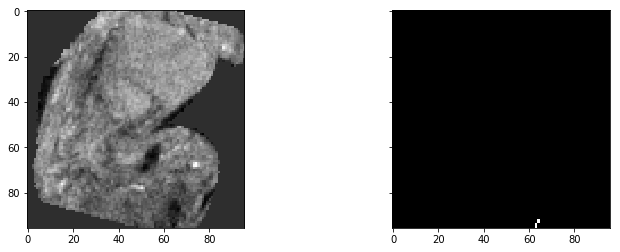

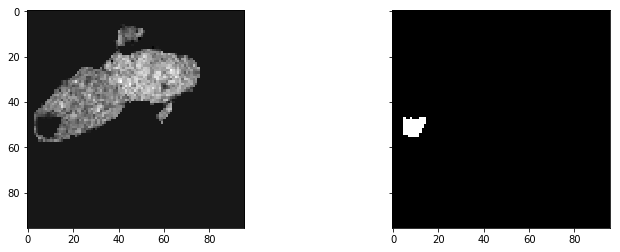

1 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


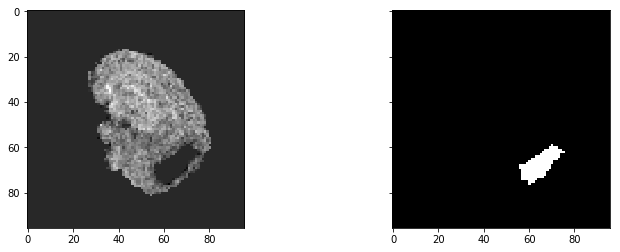

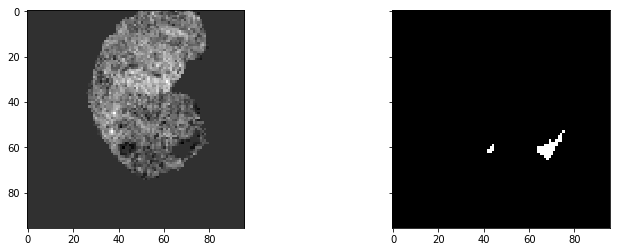

2 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


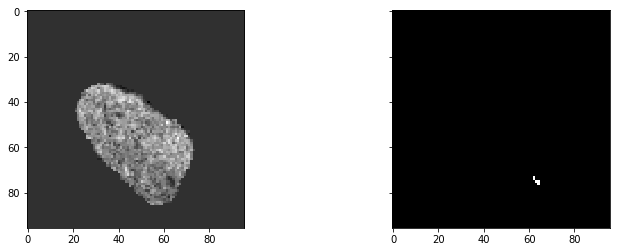

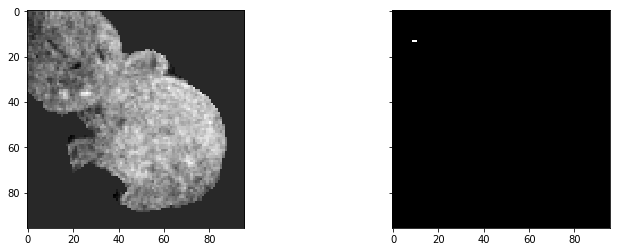

3 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


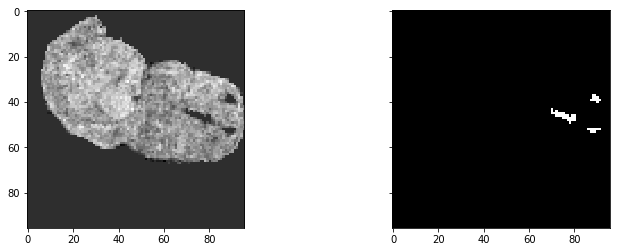

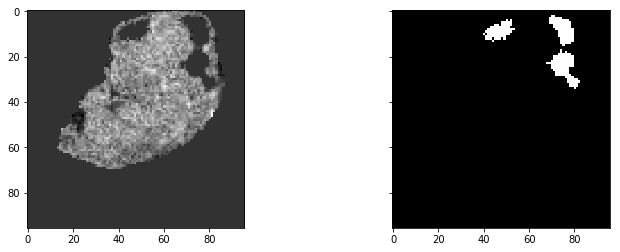

In [6]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), \
          sample_batched['label'].size())
    show_batch_image(sample_batched['image'],sample_batched['label'],BATCH_SIZE)

    # observe 4th batch and stop.
    if i_batch == 3:
        break

In [5]:
from vnet import VNet
#-------------------------NEW MODEL INIT WEIGHT--------------------------------------#

model = VNet(classnum=1, slim=False)
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = optim.SGD (model.parameters(),lr=LEARNING_RATE, momentum=0.99)

In [6]:
from loss import *

train(model, train_loader, validation_loader, optimizer,\
      device=device, dtype=dtype, lossFun=dice_loss_single, epochs=1500, print_every=100)

epoch 0 begins: 
     Iteration 0, loss = 0.9912
     validation loss = 0.9734
epoch 1 begins: 
     Iteration 0, loss = 0.9704
     validation loss = 0.9699
epoch 2 begins: 
     Iteration 0, loss = 0.9562
     validation loss = 0.9613
epoch 3 begins: 
     Iteration 0, loss = 0.9446
     validation loss = 0.9518
epoch 4 begins: 
     Iteration 0, loss = 0.9780
     validation loss = 0.9465
epoch 5 begins: 
     Iteration 0, loss = 0.9707
     validation loss = 0.9481
epoch 6 begins: 
     Iteration 0, loss = 0.9614
     validation loss = 0.9375
epoch 7 begins: 
     Iteration 0, loss = 0.8970
     validation loss = 0.9293
epoch 8 begins: 
     Iteration 0, loss = 0.9489
     validation loss = 0.9247
epoch 9 begins: 
     Iteration 0, loss = 0.9314
     validation loss = 0.9244
epoch 10 begins: 
     Iteration 0, loss = 0.8801
     validation loss = 0.9170
epoch 11 begins: 
     Iteration 0, loss = 0.9314
     validation loss = 0.8794
epoch 12 begins: 
     Iteration 0, loss = 0.9094


     validation loss = 0.5860
epoch 103 begins: 
     Iteration 0, loss = 0.5823
     validation loss = 0.5355
epoch 104 begins: 
     Iteration 0, loss = 0.5395
     validation loss = 0.6331
epoch 105 begins: 
     Iteration 0, loss = 0.5434
     validation loss = 0.5462
epoch 106 begins: 
     Iteration 0, loss = 0.5718
     validation loss = 0.5401
epoch 107 begins: 
     Iteration 0, loss = 0.4536
     validation loss = 0.5486
epoch 108 begins: 
     Iteration 0, loss = 0.4385
     validation loss = 0.5422
epoch 109 begins: 
     Iteration 0, loss = 0.4182
     validation loss = 0.6112
epoch 110 begins: 
     Iteration 0, loss = 0.5379
     validation loss = 0.5713
epoch 111 begins: 
     Iteration 0, loss = 0.5618
     validation loss = 0.5613
epoch 112 begins: 
     Iteration 0, loss = 0.5024
     validation loss = 0.5560
epoch 113 begins: 
     Iteration 0, loss = 0.4555
     validation loss = 0.6041
epoch 114 begins: 
     Iteration 0, loss = 0.5732
     validation loss = 0.566

epoch 201 begins: 
     Iteration 0, loss = 0.5928
     validation loss = 0.4955
epoch 202 begins: 
     Iteration 0, loss = 0.4049
     validation loss = 0.4899
epoch 203 begins: 
     Iteration 0, loss = 0.3921
     validation loss = 0.4945
epoch 204 begins: 
     Iteration 0, loss = 0.3806
     validation loss = 0.4885
epoch 205 begins: 
     Iteration 0, loss = 0.4820
     validation loss = 0.5165
epoch 206 begins: 
     Iteration 0, loss = 0.4359
     validation loss = 0.4937
epoch 207 begins: 
     Iteration 0, loss = 0.5210
     validation loss = 0.4886
epoch 208 begins: 
     Iteration 0, loss = 0.5609
     validation loss = 0.4942
epoch 209 begins: 
     Iteration 0, loss = 0.4255
     validation loss = 0.4952
epoch 210 begins: 
     Iteration 0, loss = 0.4290
     validation loss = 0.4921
epoch 211 begins: 
     Iteration 0, loss = 0.4600
     validation loss = 0.4998
epoch 212 begins: 
     Iteration 0, loss = 0.4935
     validation loss = 0.4984
epoch 213 begins: 
     Iter

Traceback (most recent call last):
  File "/home/xu/anaconda3/envs/cs231/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/xu/anaconda3/envs/cs231/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/xu/anaconda3/envs/cs231/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/xu/anaconda3/envs/cs231/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/xu/anaconda3/envs/cs231/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/xu/anaconda3/envs/cs231/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/xu/anaconda3/envs/cs231/lib/python3.6/multiprocessing/co

KeyboardInterrupt: 

In [ ]:
#-------------------------SAVE THE MODEL STATE DICT----------------------------------#
PATH = 'Vet_Mask_class_2'
torch.save(model.state_dict(), PATH)